In [1]:
from opr_structs import *
from opr_logic import *
from pprint import pprint
import copy

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")
logger.setLevel(logging.WARNING)

from contextlib import contextmanager

@contextmanager
def loggingcm(level=logging.DEBUG):
    # Code to acquire resource, e.g.:
    logger.setLevel(level)
    try:
        yield
    finally:
        # Code to release resource, e.g.:
        logger.setLevel(logging.WARNING)

with loggingcm():
    logger.debug("debug1")
logger.debug("debug2")

DEBUG:root:test
DEBUG:root:debug1


In [3]:
from units import *
from opr_ai import *

In [4]:
import matplotlib.pyplot as plt

def plot_items(ax, items, name_func):
    y = []
    x = []
    names = []
    for i in items:
        x.append(i.x)
        y.append(i.y)
        name = name_func(i) #f"{u.name} ({len(u.models)}/{u.starting_models})"
        names.append(name)
    
    ax.scatter(x, y)
    for i, n in enumerate(names):
        ax.annotate(n, (x[i], y[i]))

def plot_battle(battle, cursor_x=0, cursor_y=0):
    fig = plt.figure(figsize=(10,8))
    ax = fig.subplots()
    for p in battle.players:
        plot_items(ax, [u for u in p.units if u.alive], lambda u: f"{u.name} ({len(u.models)}/{u.starting_models})")
    
    plot_items(ax, battle.objectives, lambda o: f"{o.controller}")
    
    ax.scatter(cursor_x, cursor_y, c="red")
    ax.set_xlim([0, 72])
    ax.set_ylim([0, 48])
    
    
    plt.gca().set_aspect('equal')
    

    plt.show()

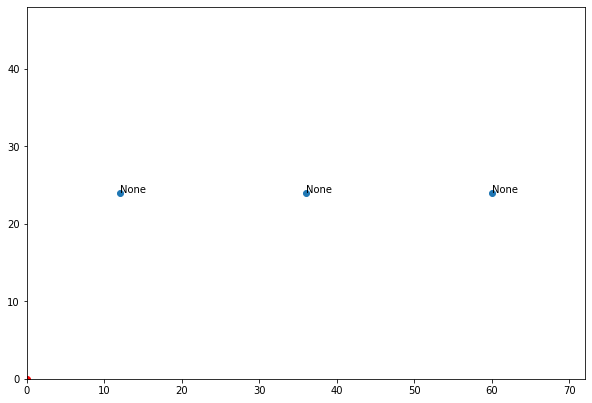

In [5]:
plot_battle(Battle([]))

In [10]:
import tqdm
def mc(func, times=10000):
    results = []
    for i in tqdm.tqdm(range(times)):
        results.append(func())
    return sum(results) / len(results)

In [33]:
def eval_options(options, eval_func):
    best = options[0]
    best_val = eval_func(options[0])
    for option in options[1:]:
        val = eval_func(option)
        if val > best_val:
            best = option
            best_val = val
    return best

In [14]:
def a_choose_unit_to_activate(battle, player):
    available_units = [u for u in player.units if "Activated" not in u.rules and u.alive]
    if not available_units:
        return None
    
    # pick a non-fatigued impact unit first
    nfi = [u for u in available_units if "Fatigued" not in u.rules and "Impact" in u.models[-1].rules]
    if nfi:
        return random.sample(nfi, 1)[0]
    
    # TODO sample from a zone, with priority baseed on rules
    # for now, just sample a random unit
    return random.sample(available_units, 1)[0]

In [29]:
def a_choose_action_for_unit(battle, player, unit):
    # if unit is wavering/shaken, they can only hold
    if "Wavering" in unit.rules:
        return ("Hold",)
    speed = unit.speed
    
    # TODO decision tree for unit types, for now move towards nearest enemy unit
    enemy_units = [u for u in battle.all_units if u.controller != player.name and u.alive]
    
    if not enemy_units:
        not_controlled = [o for o in battle.objectives if o.controller != player.name]
        
        if not not_controlled:
            return "Hold", None
        
        closest_obj = get_closest(unit.x, unit.y, not_controlled)
        distance_to = calc_distance(unit.x, unit.y, closest_obj.x, closest_obj.y)
        return "Rush", min(speed * 2, distance_to + 2.5), get_angle_to(unit.x, unit.y, closest_obj)
    
    closest = get_closest(unit.x, unit.y, enemy_units)
    distance_to_closest = calc_distance(unit.x, unit.y, closest.x, closest.y)
    
    # now that we have the closest, figure out the angle to them. 
    angle = get_angle_to(unit.x, unit.y, closest)
    
    
    # melee decision tree
    if unit.is_melee:
        not_controlled = [o for o in battle.objectives if o.controller != player.name]
        if not_controlled:
            closest_obj = get_closest(unit.x, unit.y, not_controlled)
            distance_to = calc_distance(unit.x, unit.y, closest_obj.x, closest_obj.y)
            enemies_in_way = [u for u in units_in_way(battle, unit, closest_obj) if u.controller != player.name and u.alive and calc_distance(u.x, u.y, closest_obj.x, closest_obj.y) < (distance_to + 3.5)]
            if enemies_in_way:
                closest_in_way = get_closest(unit.x, unit.y, enemies_in_way)
                if calc_distance(*unpack_points(unit, closest_in_way)) <= speed * 2:
                    return "Charge", closest_in_way
            return "Rush", min(speed * 2, distance_to + 2.5), get_angle_to(unit.x, unit.y, closest_obj)
        else: # 3
            if distance_to_closest <= speed * 2:
                return "Charge", closest
            return "Rush", speed * 2, angle
    
    elif unit.is_ranged:
#         u_range = unit.range
#         if unit.range > distance_to_closest:
#             return "Advance", 0, 0, closest
        shootable_distance = speed + unit.range
        in_range = [u for u in enemy_units if calc_distance(unit.x, unit.y, u.x, u.y) <= shootable_distance]
        if in_range:
            target = random.choice(in_range)
            for unit in in_range:
                if "Wavering" in unit.rules:
                    continue
                
                dist_to_morale = len(unit.models) - unit.starting_models / 2
                target_to_morale = len(target.models) - target.starting_models / 2
                if dist_to_morale < target_to_morale:
                    log.debug(f"switching target to {unit}, {dist_to_morale} {target_to_morale}")
                    target = unit
        else:
            target = closest
        
        angle = get_angle_to(unit.x, unit.y, target)
        distance_to_target = calc_distance(unit.x, unit.y, target.x, target.y)
        
        dist_to_move = max(0, min(distance_to_target - 3, speed))
        
        return "Advance", dist_to_move, angle, target
                                 
    
    if not unit.is_melee:
        
        dist_to_move = max(0, min(distance_to_closest - 2, speed))
        
        return "Advance", dist_to_move, angle, closest
    
    if distance_to_closest <= speed * 2:
        return "Charge", closest
    
    return "Rush", speed * 2, angle




def advanced_activation(battle, player):
    unit = a_choose_unit_to_activate(battle, player)
    if unit is None:
        log.debug(f"skipping {player}")
        return (None, None)

    action = a_choose_action_for_unit(battle, player, unit)
    return (unit, action)

In [30]:
import random
def nvn_full(a, b, draw_value=0.5):
    random.shuffle(a)
    random.shuffle(b)
    # start units at 12x12 and increment by 6 for each
    for i, u in enumerate(a):
        u.y = 11.5
        u.x = 6 + i * 6
    
    for i, u in enumerate(b):
        u.y = 36.5
        u.x = 6 + i * 6
        
    p1 = Player("p1", a, (0, 12, 0, 72))
    p2 = Player("p2", b, (36, 48, 0, 72))
    
    p1.activation = advanced_activation
    p2.activation = basic_activation
    
    battle = Battle([p1, p2])
    obj_x = 6 + (len(a) - 1) * 3
    battle.objectives = [Objective(obj_x, 24),]
#     check_objectives(battle)
    
#     run_battle(battle)
    if logger.getEffectiveLevel() <= 10:
        plot_battle(battle)
    next_player = 0
    for i in range(4):
        next_player = do_round(battle, next_player)
        if logger.getEffectiveLevel() <= 10:
            plot_battle(battle)
            print("Units:")
            pprint(battle.all_units)
            pprint(battle.objectives)
        
    if battle.objectives[0].controller is None:
        return 0.5
    elif battle.objectives[0].controller == p1.name:
        return 1
    else:
        return 0

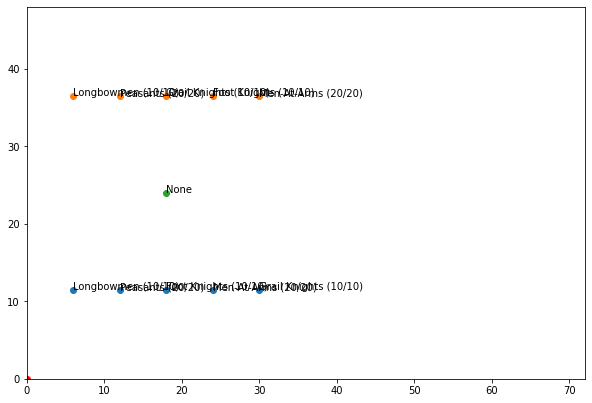

DEBUG:opr_logic:Starting Round 1
DEBUG:opr_logic:executing Unit(Grail Knights (10/10)(30.0,11.5), ('Rush', 16, 2.376599820878883)
DEBUG:opr_logic:executing Unit(Grail Knights (10/10)(18.0,36.5), ('Charge', Unit(Grail Knights a(10/10)(18.9,23.0))
DEBUG:opr_logic:Unit(Grail Knights a(10/10)(18.8,25.0) strikes Unit(Grail Knights a(10/10)(18.9,23.0)
DEBUG:opr_logic:num impact: 10
DEBUG:opr_logic:20 attacks
DEBUG:opr_logic:10 hits
DEBUG:opr_logic:6 wounds
DEBUG:opr_logic:Unit(Grail Knights a(4/10)(18.9,23.0) strikes Unit(Grail Knights fa(10/10)(18.8,25.0)
DEBUG:opr_logic:4 attacks
DEBUG:opr_logic:4 hits
DEBUG:opr_logic:1 wounds
DEBUG:opr_logic:scores: a: 7, d: 1
DEBUG:opr_structs:Grail Knights doing morale test
DEBUG:opr_ai:switching target to Unit(Grail Knights fa(9/10)(18.7,26.0), 4.0 5.0
DEBUG:opr_logic:executing Unit(Longbowmen (10/10)(6.0,11.5), ('Advance', 6, 0.82309211098452, Unit(Grail Knights fa(9/10)(18.7,26.0))
DEBUG:opr_logic:Unit(Longbowmen a(10/10)(1.6,7.4) shooting at Unit(Gr

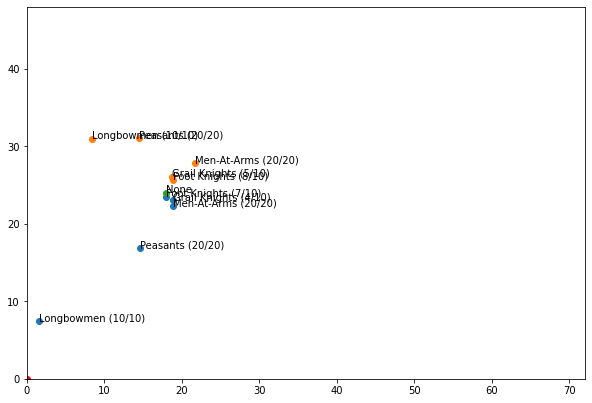

DEBUG:opr_logic:Starting Round 2
DEBUG:opr_logic:executing Unit(Grail Knights (4/10)(18.9,23.0), ('Charge', Unit(Foot Knights (8/10)(18.8,25.7))
DEBUG:opr_logic:Unit(Grail Knights a(4/10)(18.9,23.7) strikes Unit(Foot Knights (8/10)(18.8,25.7)
DEBUG:opr_logic:num impact: 4
DEBUG:opr_logic:8 attacks
DEBUG:opr_logic:6 hits
DEBUG:opr_logic:4 wounds
DEBUG:opr_logic:Unit(Foot Knights (4/10)(18.8,25.7) strikes Unit(Grail Knights fa(4/10)(18.9,23.7)
DEBUG:opr_logic:4 attacks
DEBUG:opr_logic:0 hits
DEBUG:opr_logic:0 wounds
DEBUG:opr_logic:scores: a: 4, d: 0
DEBUG:opr_structs:Foot Knights doing morale test
DEBUG:opr_logic:executing Unit(Grail Knights (5/10)(18.7,26.0), ('Charge', Unit(Foot Knights (7/10)(18.0,23.5))
DEBUG:opr_logic:Unit(Grail Knights a(5/10)(18.5,25.4) strikes Unit(Foot Knights (7/10)(18.0,23.5)
DEBUG:opr_logic:num impact: 5
DEBUG:opr_logic:10 attacks
DEBUG:opr_logic:9 hits
DEBUG:opr_logic:6 wounds
DEBUG:opr_logic:Unit(Foot Knights (1/10)(18.0,23.5) strikes Unit(Grail Knights fa

Units:
[Unit(Longbowmen a(10/10)(1.6,7.4),
 Unit(Peasants a(20/20)(14.6,16.9),
 Unit(Foot Knights a(7/10)(18.0,23.5),
 Unit(Men-At-Arms a(20/20)(18.8,22.3),
 Unit(Grail Knights fa(4/10)(18.9,23.0),
 Unit(Longbowmen a(10/10)(8.4,31.0),
 Unit(Peasants a(20/20)(14.5,31.1),
 Unit(Grail Knights fa(5/10)(18.7,26.0),
 Unit(Foot Knights a(8/10)(18.8,25.7),
 Unit(Men-At-Arms a(20/20)(21.7,27.8)]
[Objective(18, 24, None)]


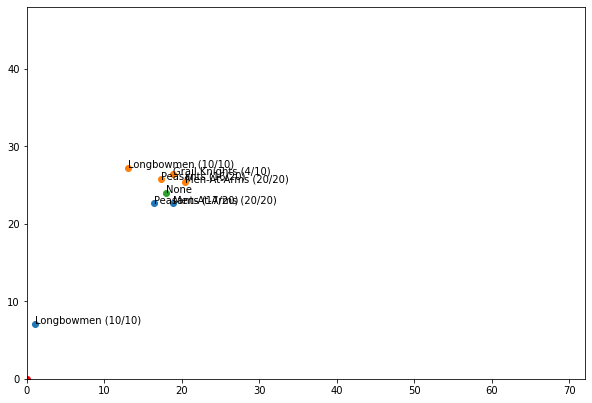

DEBUG:opr_logic:Starting Round 3
DEBUG:opr_logic:executing Unit(Peasants (17/20)(16.4,22.6), ('Advance', 1.2470911263525122, -2.8429731346449065, Unit(Peasants (16/20)(17.3,25.7))
DEBUG:opr_logic:Unit(Peasants a(17/20)(16.7,23.8) shooting at Unit(Peasants (16/20)(17.3,25.7)
DEBUG:opr_logic:17 attacks
DEBUG:opr_logic:4 hits
DEBUG:opr_logic:3 wounds
DEBUG:opr_logic:executing Unit(Grail Knights (4/10)(18.8,26.4), ('Charge', Unit(Peasants a(17/20)(16.7,23.8))
DEBUG:opr_logic:Unit(Grail Knights a(4/10)(18.0,25.4) strikes Unit(Peasants a(17/20)(16.7,23.8)
DEBUG:opr_logic:num impact: 4
DEBUG:opr_logic:8 attacks
DEBUG:opr_logic:6 hits
DEBUG:opr_logic:6 wounds
DEBUG:opr_logic:Unit(Peasants a(11/20)(16.7,23.8) strikes Unit(Grail Knights fa(4/10)(18.0,25.4)
DEBUG:opr_logic:10 attacks
DEBUG:opr_logic:2 hits
DEBUG:opr_logic:1 wounds
DEBUG:opr_logic:scores: a: 6, d: 3
DEBUG:opr_structs:Peasants doing morale test
DEBUG:opr_structs:Peasants failed morale test
DEBUG:opr_logic:executing Unit(Longbowmen 

Units:
[Unit(Longbowmen a(10/10)(1.1,7.1),
 Unit(Peasants a(17/20)(16.4,22.6),
 Unit(Foot Knights f(0/10)(18.0,23.5),
 Unit(Men-At-Arms fa(20/20)(18.8,22.7),
 Unit(Grail Knights fsa(0/10)(18.9,22.7),
 Unit(Longbowmen a(10/10)(13.1,27.3),
 Unit(Peasants a(16/20)(17.3,25.7),
 Unit(Grail Knights fa(4/10)(18.8,26.4),
 Unit(Foot Knights fa(0/10)(18.8,25.7),
 Unit(Men-At-Arms fa(20/20)(20.3,25.3)]
[Objective(18, 24, None)]


DEBUG:opr_structs:Longbowmen doing morale test
DEBUG:opr_structs:Longbowmen failed morale test
DEBUG:opr_logic:executing Unit(Peasants (13/20)(17.3,25.7), ('Advance', 0, 0.2986195189448862, Unit(Peasants fsa(8/20)(16.7,23.8))
DEBUG:opr_logic:Unit(Peasants a(13/20)(17.3,25.7) shooting at Unit(Peasants fsa(8/20)(16.7,23.8)
DEBUG:opr_logic:13 attacks
DEBUG:opr_logic:2 hits
DEBUG:opr_logic:2 wounds
DEBUG:opr_structs:Peasants doing ranged morale test
DEBUG:opr_structs:Peasants failed ranged morale test
DEBUG:opr_ai:skipping <opr_structs.Player object at 0x7f74f1992580>
DEBUG:opr_logic:skipping <opr_structs.Player object at 0x7f74f1992580>
DEBUG:opr_logic:executing Unit(Men-At-Arms (20/20)(20.3,25.3), ('Charge', Unit(Men-At-Arms fa(18/20)(18.8,22.7))
DEBUG:opr_logic:Unit(Men-At-Arms a(20/20)(19.8,24.4) strikes Unit(Men-At-Arms fa(18/20)(18.8,22.7)
DEBUG:opr_logic:10 attacks
DEBUG:opr_logic:1 hits
DEBUG:opr_logic:0 wounds
DEBUG:opr_logic:Unit(Men-At-Arms fa(18/20)(18.8,22.7) strikes Unit(Men-

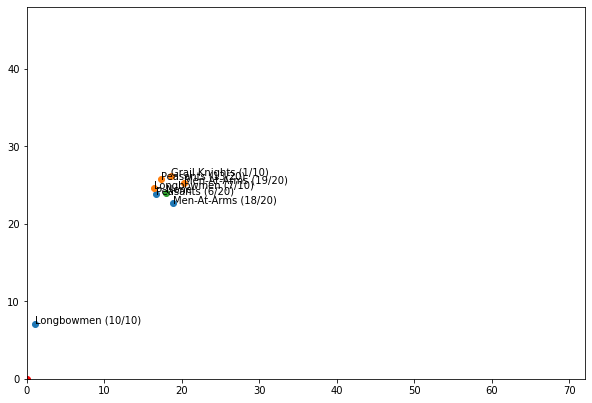

DEBUG:opr_logic:Starting Round 4
DEBUG:opr_logic:executing Unit(Men-At-Arms (18/20)(18.8,22.7), ('Charge', Unit(Longbowmen s(7/10)(16.5,24.6))
DEBUG:opr_logic:Unit(Men-At-Arms a(18/20)(18.0,23.3) strikes Unit(Longbowmen s(7/10)(16.5,24.6)
DEBUG:opr_logic:10 attacks
DEBUG:opr_logic:4 hits
DEBUG:opr_logic:1 wounds
DEBUG:opr_logic:Unit(Longbowmen s(6/10)(16.5,24.6) strikes Unit(Men-At-Arms fa(18/20)(18.0,23.3)
DEBUG:opr_logic:6 attacks
DEBUG:opr_logic:1 hits
DEBUG:opr_logic:1 wounds
DEBUG:opr_logic:scores: a: 4, d: 2
DEBUG:opr_structs:Longbowmen doing morale test
DEBUG:opr_structs:Longbowmen failed morale test
DEBUG:opr_logic:executing Unit(Grail Knights (1/10)(18.6,26.2), ('Charge', Unit(Peasants s(6/20)(16.7,23.8))
DEBUG:opr_logic:Unit(Grail Knights a(1/10)(18.0,25.4) strikes Unit(Peasants s(6/20)(16.7,23.8)
DEBUG:opr_logic:num impact: 1
DEBUG:opr_logic:2 attacks
DEBUG:opr_logic:1 hits
DEBUG:opr_logic:1 wounds
DEBUG:opr_logic:Unit(Peasants s(5/20)(16.7,23.8) strikes Unit(Grail Knights f

Units:
[Unit(Longbowmen a(10/10)(1.1,7.1),
 Unit(Peasants fsa(6/20)(16.7,23.8),
 Unit(Foot Knights (0/10)(18.0,23.5),
 Unit(Men-At-Arms fa(18/20)(18.8,22.7),
 Unit(Grail Knights s(0/10)(18.9,22.7),
 Unit(Longbowmen fsa(7/10)(16.5,24.6),
 Unit(Peasants a(13/20)(17.3,25.7),
 Unit(Grail Knights fa(1/10)(18.6,26.2),
 Unit(Foot Knights (0/10)(18.8,25.7),
 Unit(Men-At-Arms fsa(19/20)(20.3,25.3)]
[Objective(18, 24, None)]


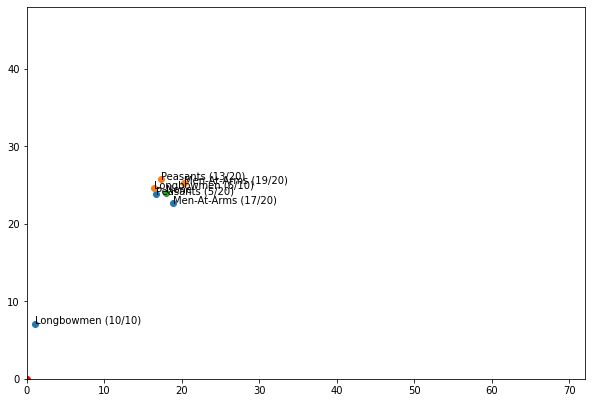

Units:
[Unit(Longbowmen a(10/10)(1.1,7.1),
 Unit(Peasants fa(5/20)(16.7,23.8),
 Unit(Foot Knights (0/10)(18.0,23.5),
 Unit(Men-At-Arms fa(17/20)(18.8,22.7),
 Unit(Grail Knights s(0/10)(18.9,22.7),
 Unit(Longbowmen fa(6/10)(16.5,24.6),
 Unit(Peasants a(13/20)(17.3,25.7),
 Unit(Grail Knights fa(0/10)(18.6,26.2),
 Unit(Foot Knights (0/10)(18.8,25.7),
 Unit(Men-At-Arms a(19/20)(20.3,25.3)]
[Objective(18, 24, None)]
0.5


In [31]:
a = [men_at_arms,longbowmen_10,peasants,grail_knights_c,foot_knights,]
b = [men_at_arms,longbowmen_10,peasants,grail_knights_c,foot_knights,]
with loggingcm(): print(nvn_full(copify(a), copify(b)))

In [32]:
a_first = mc(lambda: nvn_full(copify(a), copify(b)), times=10000)
b_first = 1 - mc(lambda: nvn_full(copify(b), copify(a)), times=10000)
(a_first + b_first) / 2, a_first, b_first

100%|████████████████████████████████████| 10000/10000 [00:49<00:00, 203.28it/s]


(0.49735, 0.19645, 0.79825)

base: (0.49695, 0.2868, 0.7071000000000001)
ranged targeting smaller units: (0.50455, 0.20405, 0.80505)
ranged skipping already wavering units: (0.49735, 0.19645, 0.79825)